# Tutorial 2. Controlling an advanced experiment using MeasurementControl

In this tutorial, we will explore the more advanced features of quantify. Recall our previous definition of a `hard` loop. 


By the end of this tutorial, we will covered

In [1]:
import time

import numpy as np
import xarray as xr
from qcodes import ManualParameter, Parameter
from quantify.measurement.control import MeasurementControl
import quantify.visualization.pyqt_plotmon as pqm

ModuleNotFoundError: No module named 'quantify'

In [2]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon_MC')
MC.instr_plotmon(plotmon.name)

# A 1D hard(ware) controlled loop
## Defining a simple model

We start by defining a pair of mock devices.

DO THIS WITH A RESONATOR SPECTOSCROPY

In [3]:
freq = ManualParameter(name='frequency', unit='Hz', label='Frequency')
freq.add_parameter("soft", initial_value=False. parameter_class=ManualParameter)


class MockTransmon:
    """
    Args:
        mode (str): Number of data rows to return, supports '1D' and '2D'
    """
    def __init__(self):
        self.name = 'transmon'
        self.unit = 'A'
        self.label = 'Amplitude'
        self.soft = False
        self.resonance = random.randint(6.0e9, 6.1e9)

    def prepare(self, setpoints):
        self.setpoints = setpoints

    def get(self):
        return (self.setpoints[:, 0] == self.resonance).astype(float)


## Running the experiment
Just like our `soft` 1D loop, our complete experiment is expressed in just four lines of code.

Different from the `soft` loop is defining the `soft` property of our `Settable` and `Gettable` to False. The `MeasurementControl` will detect these settings and run in the appropriate`hard` mode.

In [4]:
MC.set_setpars(freq)
MC.set_setpoints(np.arange(6.0e9, 6.1e9)
MC.set_getpars(MockTransmon())
dset = MC.run()

 100% completed 	elapsed time: 0.0s 	time left: 0.0s


In [5]:
plotmon.main_QtPlot

<xarray.Dataset>
Dimensions:  (dim_0: 5)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 2.5 5.0 7.5 10.0
    y0       (dim_0) float64 0.0 1.021 -48.18 -0.9396 0.04153
Attributes:
    tuid:     20200605-095841-162-7f87d4
    name:     
    2D-grid:  False

# Noisy Hardware
Oftentimes we will be working with imperfect hardware. To smooth out this noise, the `MeasurementControl` provides software averaging functionality, where a loop will be run n many times and results averaged together.

## 1. A Noisy Experiment
Here our mock device will add some random noise to each measurement. Our end result isn't quite what we want

In [7]:
setpoints = np.arange(20.0)
MC.set_setpars(NoneSweep(internal=False))
MC.set_setpoints(setpoints)
d = DummyDetector('2D')
d.noise = 0.8
MC.set_getpars(d)
noisy_dset = MC.run('noisy')

xn_0 = noisy_dset['x0'].values
expected_vals = hardware_mock_values_2D(xn_0)
yn_0 = abs(noisy_dset['y0'].values - expected_vals[0])
yn_1 = abs(noisy_dset['y1'].values - expected_vals[1])

 100% completed 	elapsed time: 1.7s 	time left: 0.0s


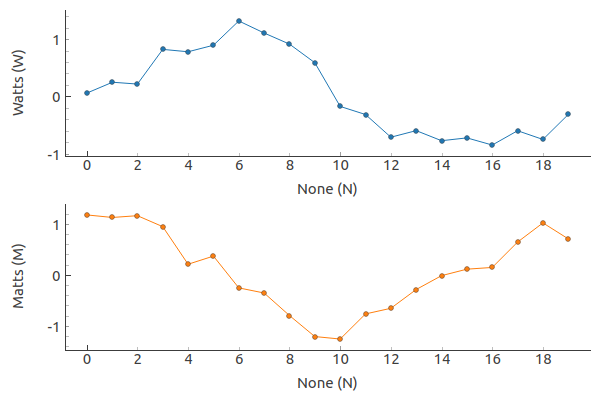

In [8]:
plotmon.main_QtPlot

## 2. An Averaged Experiment
Here we set the `soft_avg` parameter of the `MeasurementControl` to our desired number of iterations. By averaging the results of 5000 runs of our experiment, we have filtered out the noise in our hardware.

In [9]:
MC.soft_avg(5000)
MC.set_setpars(NoneSweep(internal=False))
MC.set_setpoints(setpoints)
MC.set_getpars(d)
avg_dset = MC.run('averaged')

yavg_0 = abs(avg_dset['y0'].values - expected_vals[0])
yavg_1 = abs(avg_dset['y1'].values - expected_vals[1])

 95% completed 	elapsed time: 5.6s 	time left: 0.3sss

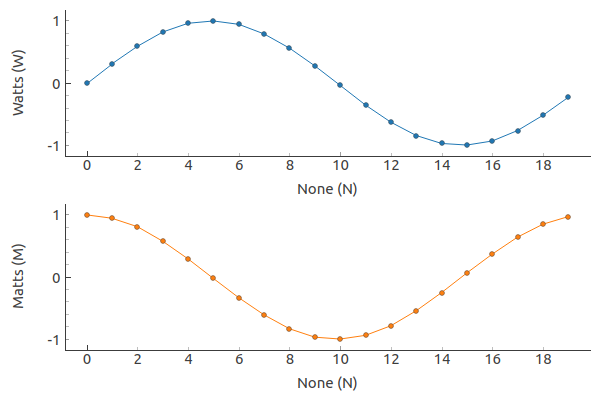

In [10]:
plotmon.main_QtPlot

We can additionally verify the average error is much larger in the noisy dataset than in adjusted dataset:

In [11]:
np.mean(yn_0)

0.18482911142916122

In [12]:
np.mean(yavg_0)

0.0029693442180660063

In [13]:
# internal set, external get

mock = ManualParameter('m', initial_value=1, unit='M', label='Mock')

def mock_func(none):
    # to also test if the values are set correctly in the sweep
    arr = np.zeros([2, 2])
    arr[0, :] = np.array([mock()])
    arr[1, :] = np.array([mock() + 2])
    return arr

d = DummyDetector(return_dimensions='2D')
d.mock_fn = mock_func
setpoints = np.repeat(np.arange(5.0), 2)

MC.set_setpars(mock)
MC.set_setpoints(setpoints)
MC.set_getpars(d)
dset = MC.run("soft_sweep_hard_det")

 100% completed 	elapsed time: 2.1s 	time left: 0.0s


In [14]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 10)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.0 1.0 1.0 2.0 2.0 3.0 3.0 4.0 4.0
    y0       (dim_0) float64 0.0 0.0 1.0 1.0 2.0 2.0 3.0 3.0 4.0 4.0
    y1       (dim_0) float64 2.0 2.0 3.0 3.0 4.0 4.0 5.0 5.0 6.0 6.0
Attributes:
    tuid:     20200605-095851-595-db906e
    name:     soft_sweep_hard_det
    2D-grid:  False

In [15]:
counter_param = ManualParameter("counter", initial_value=0)

def v_size(setpoints):
    idx = counter_param() % 3
    counter_param(counter_param() + 1)
    if idx == 0:
        return 2 * setpoints[:7]
    elif idx == 1:
        return 2 * setpoints[:4]
    elif idx == 2:
        return 2 * setpoints[:]

setpoints = np.arange(30.0)
d = DummyDetector('1D')
d.mock_fn = v_size
MC.set_setpars(NoneSweep(internal=False))
MC.set_setpoints(setpoints)
MC.set_getpars(d)
dset = MC.run('varying')

 100% completed 	elapsed time: 1.0s 	time left: 0.0s


In [16]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 30)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0 29.0
    y0       (dim_0) float64 0.0 2.0 4.0 6.0 8.0 ... 50.0 52.0 54.0 56.0 58.0
Attributes:
    tuid:     20200605-095853-862-91ba89
    name:     varying
    2D-grid:  False

In [17]:
times = np.linspace(10, 20, 3)
amps = np.linspace(0, 10, 5)

MC.set_setpars([NoneSweep(internal=False, name='t', unit='s', label='Time'), NoneSweep(internal=True, name='amp', unit='V', label='Amplitudes')])
MC.set_setpoints_grid([times, amps])
MC.set_getpars(DummyDetector("2D"))
dset = MC.run('2D Hard')

 100% completed 	elapsed time: 6.6s 	time left: 0.0s


In [18]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 15)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 10.0 15.0 20.0 10.0 15.0 ... 20.0 10.0 15.0 20.0
    x1       (dim_0) float64 0.0 0.0 0.0 2.5 2.5 2.5 ... 7.5 7.5 10.0 10.0 10.0
    y0       (dim_0) float64 -0.04149 -0.9981 0.08292 ... -0.9981 0.08292
    y1       (dim_0) float64 -0.9991 0.06222 0.9966 ... -0.9991 0.06222 0.9966
Attributes:
    tuid:     20200605-095854-981-336bef
    name:     2D Hard
    2D-grid:  True
    xlen:     3
    ylen:     5

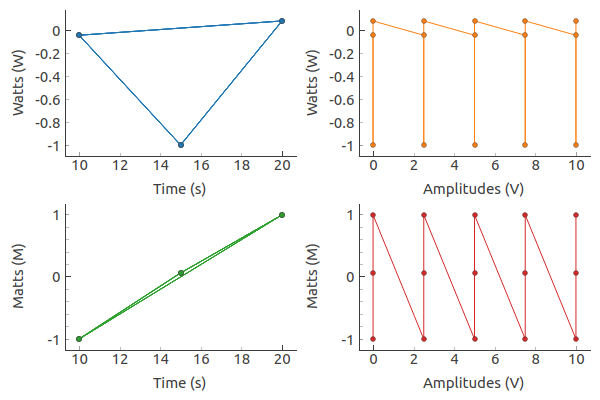

In [19]:
plotmon.main_QtPlot

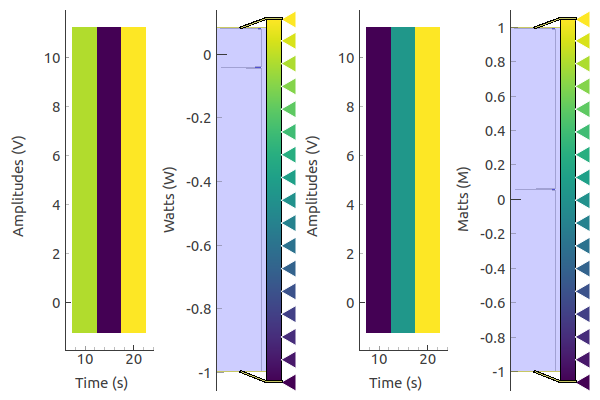

In [20]:
plotmon.secondary_QtPlot